In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
import pickle
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from numpy import interp
from itertools import cycle

from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import chi2, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

In [2]:
train_set_file = ['train_feature_fold-1.csv', #(a file is a fold)
                  'train_feature_fold-2.csv',
                  'train_feature_fold-3.csv',
                  'train_feature_fold-4.csv',
                  'train_feature_fold-5.csv'
                 ]
test_set_file = 'test_feature.csv'

classes_list = np.array(["Glaucoma","Normal","Other"])
n_classes = 3
n_folds = 5
lw = 2


In [3]:
def calculateFprTprAuc(binary_y_test, y_score):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(binary_y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(binary_y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr , tpr , roc_auc

In [4]:
def plotROC(fpr,tpr,roc_auc,title):
    #aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    #interpolate all ROC curves
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    #average tpr and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of {0} (area = {1:0.2f})'
                 ''.format(classes_list[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [5]:
########## plot confusion matrix
#class_list must be numpy array
np.set_printoptions(precision=2)
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        title = 'Normalized confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    
    cm_normalize = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm_normalize, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm_normalize.shape[1]),
           yticks=np.arange(cm_normalize.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' #if normalize else 'd'
    thresh = cm_normalize.max() / 2.
    for i in range(cm_normalize.shape[0]):
        for j in range(cm_normalize.shape[1]):
            ax.text(j, i, "{:.2%}\n({:d})".format(cm_normalize[i, j], cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm_normalize[i, j] > thresh else "black")
    fig.tight_layout()
    #plt.xlim(-0.5, len(np.unique(y))-0.5)
    #plt.ylim(len(np.unique(y))-0.5, -0.5)
    plt.show()
    
    
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # F1-score
    F1 = 2*((PPV*TPR)/(PPV+TPR))
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)

    print("="*60)
    print("{:<26} | {:>8} {:>8} {:>8}".format("value", "Glaucoma", "Normal", "Other"))
    print("="*60)
    print("{:<26} | {:>8.2f} {:>8.2f} {:>8.2f}".format("Sensitivity(TPR)", TPR[0], TPR[1], TPR[2]))
    print("{:<26} | {:>8.2f} {:>8.2f} {:>8.2f}".format("Specificity(TNR)", TNR[0], TNR[1], TNR[2]))
    print("{:<26} | {:>8.2f} {:>8.2f} {:>8.2f}".format("Precision(PPV)", PPV[0], PPV[1], PPV[2]))
    print("{:<26} | {:>8.2f} {:>8.2f} {:>8.2f}".format("Negative predictive value", NPV[0], NPV[1], NPV[2]))
    print("{:<26} | {:>8.2f} {:>8.2f} {:>8.2f}".format("False positive rate", FPR[0], FPR[1], FPR[2]))
    print("{:<26} | {:>8.2f} {:>8.2f} {:>8.2f}".format("False negative rate", FNR[0], FNR[1], FNR[2]))
    print("{:<26} | {:>8.2f} {:>8.2f} {:>8.2f}".format("False discovery rate", FDR[0], FDR[1], FDR[2]))
    print("{:<26} | {:>8.2f} {:>8.2f} {:>8.2f}".format("F1-score", F1[0], F1[1], F1[2]))
    print("{:<26} | {:>8.2f} {:>8.2f} {:>8.2f}".format("Overall accuracy", ACC[0], ACC[1], ACC[2]))

# Plot non-normalized confusion matrix


# Plot normalized confusion matrix
#plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,title='Normalized confusion matrix')


In [6]:
#read data set
train_set_list = [pd.read_csv(file_path) for file_path in train_set_file]
test_set = pd.read_csv(test_set_file)

In [7]:
#separate X and y
X_train = [train_set.iloc[:, 2:].values for train_set in train_set_list]
y_train = [train_set.iloc[:, 1].values for train_set in train_set_list]
X_test = test_set.iloc[:, 2:].values
y_test = test_set.iloc[:, 1].values

feature_names = list(test_set.columns)[2:]

In [8]:
# Feature Scaling Object
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

#5-fold Extraction
from sklearn.model_selection import KFold
X = np.array(X_train)
y = np.array(y_train)
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

Training

----------------- fold 1 -----------------
training model
train finished


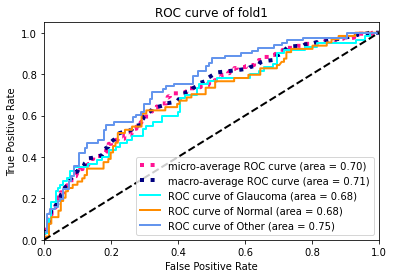

best model is fold 1
----------------- fold 2 -----------------
training model
train finished


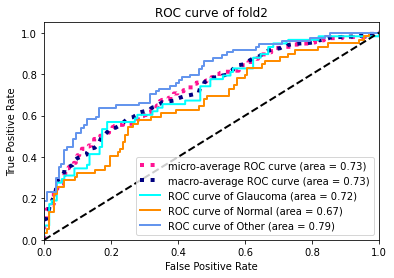

best model is fold 2
----------------- fold 3 -----------------
training model
train finished


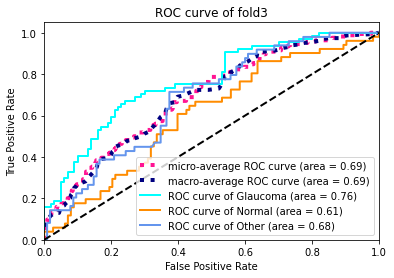

----------------- fold 4 -----------------
training model
train finished


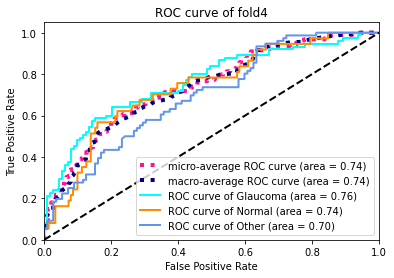

best model is fold 4
----------------- fold 5 -----------------
training model
train finished


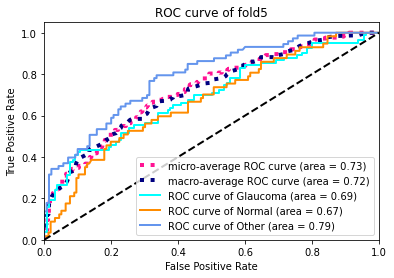


all fold train finished


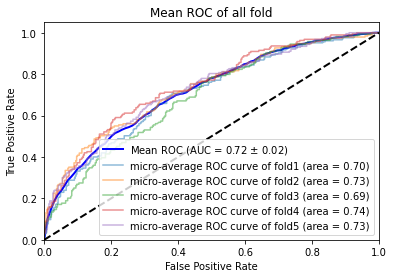

In [9]:
#training
mean_fpr = np.linspace(0, 1, 100)
interp_tpr_all_fold = []
aucs = []
fprs = []
tprs = []
bestAUC = 0
for i ,(train_index, val_index) in enumerate(kf.split(X)):
    
    print("----------------- fold",i+1,"-----------------")
    
    
    
    X_train = sc.fit_transform(np.concatenate(X[train_index],axis=0))
    X_val = sc.transform(X[val_index][0])
    y_train = np.concatenate(y[train_index],axis=0)
    y_val = y[val_index][0]
    
    print("training model")
#     clf = Pipeline([
#           ('feature_selection', SelectFromModel(RandomForestClassifier(n_estimators = 400, criterion = "gini"))),
#           ('classification', RandomForestClassifier(n_estimators = 400, criterion = "gini"))
#     ])
    clf = RandomForestClassifier(n_estimators = 400, criterion = "gini")
    model = OneVsRestClassifier(clf)
    
    #RandomForestClassifier(n_estimators = 400, criterion = "gini")
    #model = OneVsRestClassifier(SVC(kernel='rbf',probability=True))
    
    #svm = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5))
    #kernel = {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
    model.fit(X_train, y_train)
    
    
    #svm.fit(X_train, y_train)
    print("train finished")
    #print("training RF)
    #rf = RandomForestClassifier(n_estimators = 400, criterion = "gini")
    #rf.fit(X_train, y_train)
    
    #y_pred_svm = svm.predict(X_val)
    #y_pred_rf = rf.predict(X_val)
    #print("train finished")
    
    #save model
    #pickle.dump(svm, open("svm_" + (fold+1) + ".sav" , 'wb'))
    #pickle.dump(rf, open("rf" + (fold+1) + ".sav" , 'wb'))
    
    #print("validate SVM")
    
    binary_y_val = label_binarize(y_val, classes=[0, 1, 2])
    
    fpr, tpr, roc_auc = calculateFprTprAuc(binary_y_val, model.predict_proba(X_val))
    plotROC(fpr,tpr,roc_auc,"ROC curve of fold"+ str(i+1))
    tprs.append(tpr["micro"])
    fprs.append(fpr["micro"])
    
    interp_tpr = np.interp(mean_fpr, fpr["micro"], tpr["micro"])
    interp_tpr[0] = 0.0
    interp_tpr_all_fold.append(interp_tpr)
    aucs.append(roc_auc["micro"])
    
    if roc_auc["micro"] > bestAUC:
        bestAUC = roc_auc["micro"]
        bestModel = model
        print("best model is fold",i+1)
    

print()    
print("all fold train finished")

mean_tpr = np.mean(interp_tpr_all_fold, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

std_tpr = np.std(interp_tpr_all_fold, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.show()

plt.figure()
plt.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2)

for i in range(5):
    plt.plot(fprs[i], tprs[i],
         label='micro-average ROC curve of fold{} (area = {:0.2f})'.format(i+1,aucs[i]), alpha=.5)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
# plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
#                 label=r'$\pm$ 1 std. dev.')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC of all fold')
plt.legend(loc="lower right")
plt.show()

In [10]:
X_test = sc.transform(X_test)

# y_score_svm_list.append(model.decision_function(X_test))
# y_predict_svm_list.append(model.predict(X_test))
# y_prob_svm_list.append(model.predict_proba(X_test))
# print("test finish")

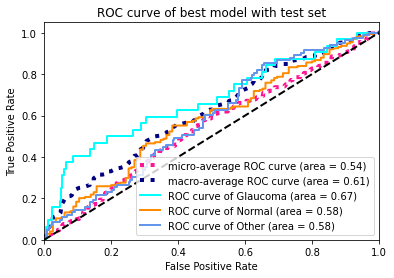

In [11]:
binary_y_test = label_binarize(y_test, classes=[0, 1, 2])

fpr, tpr, roc_auc = calculateFprTprAuc(binary_y_test, bestModel.predict_proba(X_test))
plotROC(fpr,tpr,roc_auc,"ROC curve of best model with test set")

Normalized confusion matrix


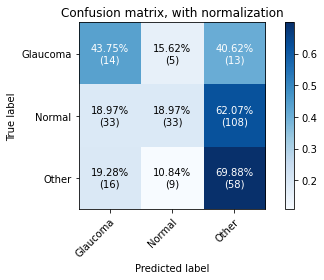

value                      | Glaucoma   Normal    Other
Sensitivity(TPR)           |     0.44     0.19     0.70
Specificity(TNR)           |     0.81     0.88     0.41
Precision(PPV)             |     0.22     0.70     0.32
Negative predictive value  |     0.92     0.42     0.77
False positive rate        |     0.19     0.12     0.59
False negative rate        |     0.56     0.81     0.30
False discovery rate       |     0.78     0.30     0.68
F1-score                   |     0.29     0.30     0.44
Overall accuracy           |     0.77     0.46     0.49


In [12]:
y_pred = bestModel.predict(X_test)
plot_confusion_matrix(y_test,y_pred, classes=classes_list,title='Confusion matrix, with normalization')